### script for time series analysis of fronts in Bukovsky region
### date created: 31 Aug. 2021
### author: doughert@ucar.edu

In [3]:
import math 
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
from dask.distributed import Client

### import y-front 

In [4]:
yfront_df = pd.read_csv('/glade/work/doughert/asp/flood_storm_types/frontal_ID/y_fronts_daily_bukovsky_regions.csv', header=0)
yfront_df = yfront_df.drop(columns='Unnamed: 0')

### import x-front

In [5]:
xfront_df = pd.read_csv('/glade/work/doughert/asp/flood_storm_types/frontal_ID/x_fronts_daily_bukovsky_regions.csv', header=0)
xfront_df = xfront_df.drop(columns='Unnamed: 0')

In [6]:
yfront_df['front_y'] = ['y']*len(yfront_df)
xfront_df['front_x'] = ['x']*len(xfront_df)

### concat dfs

In [23]:
frontxy_df = pd.concat([yfront_df,xfront_df])

In [46]:
print(len(yfront_df))
print(len(xfront_df))
print(len(frontxy_df))

75573
75534
151107


### remove rows where occurrence = np.nan

In [26]:
frontxy_df = frontxy_df.fillna({'occurrence':0})

In [29]:
frontxy_df['date'] = pd.to_datetime(frontxy_df['date'])

In [30]:
print(frontxy_df)

       region       date  occurrence front_y front_x
0      Desert 1995-01-01         1.0       y     NaN
1      Desert 1995-01-02         1.0       y     NaN
2      Desert 1995-01-03         1.0       y     NaN
3      Desert 1995-01-04         1.0       y     NaN
4      Desert 1995-01-05         1.0       y     NaN
...       ...        ...         ...     ...     ...
75529   South 2017-12-27         0.0     NaN       x
75530   South 2017-12-28         0.0     NaN       x
75531   South 2017-12-29         0.0     NaN       x
75532   South 2017-12-30         1.0     NaN       x
75533   South 2017-12-31         1.0     NaN       x

[151107 rows x 5 columns]


### label as x/y front and drop duplicates

In [31]:
dup = frontxy_df.duplicated(subset=['region','date']).where(frontxy_df['occurrence']==1.0)

In [32]:
dup_ct = np.where(dup==1.0)[0]
print(len(dup_ct))

39936


In [38]:
frontxy_df['front_xy'] = dup

In [41]:
print(frontxy_df.iloc[0:3])

   region       date  occurrence front_y front_x  front_xy
0  Desert 1995-01-01         1.0       y     NaN       0.0
1  Desert 1995-01-02         1.0       y     NaN       0.0
2  Desert 1995-01-03         1.0       y     NaN       0.0


In [53]:
frontxy_df2 = frontxy_df.drop_duplicates(subset=['region','date', 'occurrence'], inplace=False, keep='last').reset_index()
frontxy_df2 = frontxy_df2.drop(columns='index')

In [54]:
print(len(frontxy_df2))

100567


### sortby date 

In [69]:
frontxy_df2_sort = frontxy_df2.sort_values(by='date').reset_index()
frontxy_df2_sort = frontxy_df2_sort.drop(columns='index')

In [70]:
print(frontxy_df2_sort)

           region       date  occurrence front_y front_x  front_xy
0            East 1995-01-01         1.0       y     NaN       0.0
1          Pac_SW 1995-01-01         1.0     NaN       x       1.0
2          Pac_NW 1995-01-01         1.0     NaN       x       0.0
3       MountainW 1995-01-01         1.0     NaN       x       1.0
4           South 1995-01-01         1.0     NaN       x       1.0
...           ...        ...         ...     ...     ...       ...
100562       East 2017-12-31         1.0       y     NaN       0.0
100563     Pac_NW 2017-12-31         1.0       y     NaN       0.0
100564         GP 2017-12-31         1.0     NaN       x       1.0
100565     Desert 2017-12-31         1.0     NaN       x       1.0
100566      South 2017-12-31         1.0     NaN       x       1.0

[100567 rows x 6 columns]


### remove duplicated rows where front = 0

In [99]:
dup_new =frontxy_df2_sort.duplicated(subset=['region','date'], keep=False).where(frontxy_df2_sort['occurrence']==0.0)
dup_new = dup_new.fillna(0)
frontxy_df2_sort['drop_cols'] = dup_new

In [112]:
frontxy_df2_sort_drop = frontxy_df2_sort[frontxy_df2_sort['drop_cols']==0.0].reset_index()
frontxy_df2_sort_drop = frontxy_df2_sort_drop.drop(columns='index')
frontxy_df2_sort_drop = frontxy_df2_sort_drop.drop(columns='drop_cols')
frontxy_df2_sort_drop['front_y'] = frontxy_df2_sort_drop['front_y'].fillna(0)
frontxy_df2_sort_drop['front_x'] = frontxy_df2_sort_drop['front_x'].fillna(0)

In [137]:
print(len(frontxy_df2_sort_drop ))
print(frontxy_df2_sort_drop[0:11])

75602
       region       date  occurrence front_y front_x  front_xy
0        East 1995-01-01         1.0       y       0       0.0
1      Pac_SW 1995-01-01         1.0       0       x       1.0
2      Pac_NW 1995-01-01         1.0       0       x       0.0
3   MountainW 1995-01-01         1.0       0       x       1.0
4       South 1995-01-01         1.0       0       x       1.0
5      Desert 1995-01-01         1.0       0       x       1.0
6          GP 1995-01-01         1.0       0       x       1.0
7      Praire 1995-01-01         1.0       y       0       0.0
8       Lakes 1995-01-01         1.0       y       0       0.0
9        East 1995-01-02         1.0       0       x       1.0
10      Lakes 1995-01-02         0.0       y       0       NaN


### export csv of daily frontal occurrence by region

In [135]:
frontxy_df2_sort_drop.to_csv('Frontal_daily_counts_bukovsky_regions.csv')

### separate dfs for each region

In [126]:
frontxy_pacnw = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='Pac_NW']
frontxy_pacsw = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='Pac_SW']
frontxy_mnt = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='MountainW']
frontxy_desert = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='Desert']
frontxy_gp = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='GP']
frontxy_prr = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='Praire']
frontxy_south = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='South']
frontxy_lakes = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='Lakes']
frontxy_east = frontxy_df2_sort_drop[frontxy_df2_sort_drop['region']=='East']

In [127]:
print(len(frontxy_pacnw))
print(len(frontxy_pacsw))
print(len(frontxy_mnt))
print(len(frontxy_desert))
print(len(frontxy_gp))

8401
8395
8401
8401
8401


In [128]:
dates_since_1995 = pd.DataFrame({'date':pd.date_range(start='1995-01-01', end='2017-12-31', freq='D')})

In [129]:
frontxy_pacnw_time = frontxy_pacnw.merge(dates_since_1995, how='right', on='date')
frontxy_pacsw_time = frontxy_pacsw.merge(dates_since_1995, how='right', on='date')
frontxy_mnt_time = frontxy_mnt.merge(dates_since_1995, how='right', on='date')
frontxy_desert_time = frontxy_desert.merge(dates_since_1995, how='right', on='date')
frontxy_gp_time = frontxy_gp.merge(dates_since_1995, how='right', on='date')
frontxy_prr_time = frontxy_prr.merge(dates_since_1995, how='right', on='date')
frontxy_south_time = frontxy_south.merge(dates_since_1995, how='right', on='date')
frontxy_lakes_time = frontxy_lakes.merge(dates_since_1995, how='right', on='date')
frontxy_east_time = frontxy_east.merge(dates_since_1995, how='right', on='date')

In [130]:
print(len(frontxy_pacnw_time))
print(len(frontxy_pacsw_time))
print(len(frontxy_mnt_time))
print(len(frontxy_desert_time))
print(len(frontxy_gp_time))

8401
8401
8401
8401
8401


#### replace nans with 0s in occurence

In [131]:
frontxy_pacnw_time = frontxy_pacnw_time.fillna({"occurrence":0})
frontxy_pacsw_time = frontxy_pacsw_time.fillna({"occurrence":0})
frontxy_mnt_time = frontxy_mnt_time.fillna({"occurrence":0})
frontxy_desert_time = frontxy_desert_time.fillna({"occurrence":0})
frontxy_gp_time = frontxy_gp_time.fillna({"occurrence":0})
frontxy_prr_time = frontxy_prr_time.fillna({"occurrence":0})
frontxy_south_time = frontxy_south_time.fillna({"occurrence":0})
frontxy_lakes_time = frontxy_lakes_time.fillna({"occurrence":0})
frontxy_east_time = frontxy_east_time.fillna({"occurrence":0})

#### plot time series of fronts

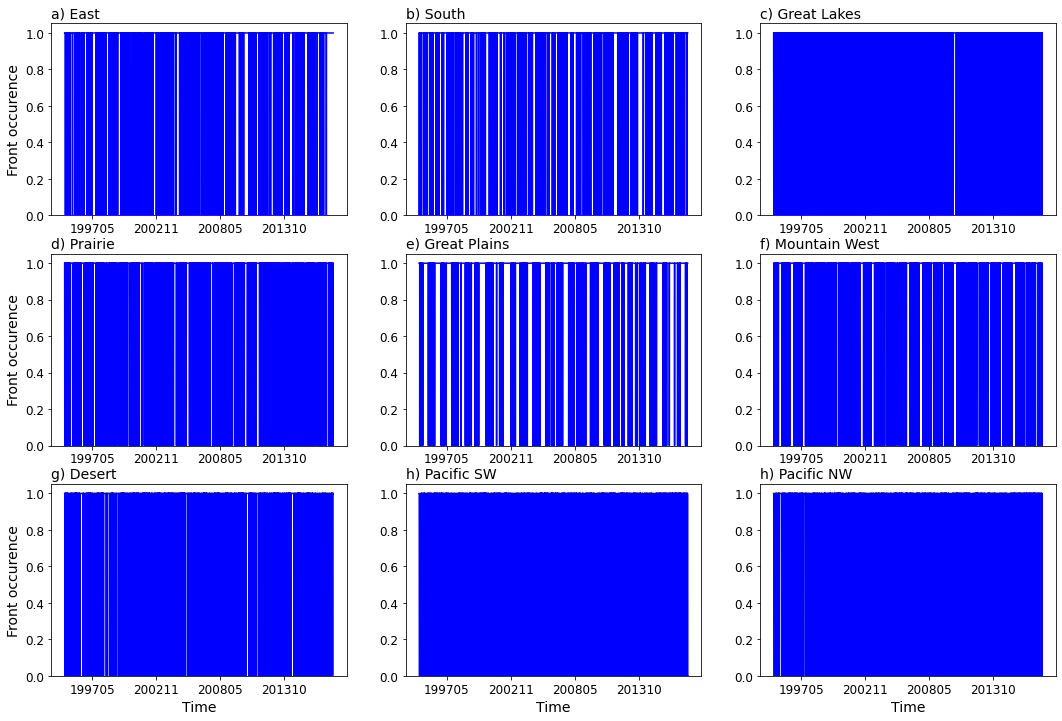

In [133]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,12))
date_plot = matplotlib.dates.date2num(frontxy_east_time['date'])
date_fmt = matplotlib.dates.DateFormatter('%Y%m')

ax1 = plt.subplot(3, 3, 1, )
ax1.plot(date_plot, frontxy_east_time['occurrence'], c='b')
#ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('Front occurence', fontsize=14)
ax1.tick_params(axis='both',labelsize=12)
ax1.xaxis.set_major_formatter(date_fmt)
ax1.set_ylim(0,1.052)
ax1.set_title('a) East', loc='left', fontsize=14)

ax2 = plt.subplot(3, 3, 2,)
ax2.plot(date_plot, frontxy_south_time['occurrence'], c='b')
#ax2.set_xlabel('Time', fontsize=14)
#ax2.set_ylabel('TC occurence', fontsize=14)
ax2.tick_params(axis='both',labelsize=12)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.set_ylim(0,1.052)
ax2.set_title('b) South', loc='left', fontsize=14)

ax3 = plt.subplot(3, 3, 3, sharex=ax1)
ax3.plot(date_plot, frontxy_lakes_time['occurrence'], c='b')
#ax3.set_xlabel('Time', fontsize=14)
#ax3.set_ylabel('TC occurence', fontsize=14)
ax3.tick_params(axis='both',labelsize=12)
ax3.xaxis.set_major_formatter(date_fmt)
ax3.set_ylim(1995,2015)
ax3.set_ylim(0,1.052)
ax3.set_title('c) Great Lakes', loc='left', fontsize=14)


ax4 = plt.subplot(3, 3, 4,sharex=ax1)
ax4.plot(date_plot, frontxy_prr_time['occurrence'], c='b')
#ax4.set_xlabel('Time', fontsize=14)
ax4.set_ylabel('Front occurence', fontsize=14)
ax4.tick_params(axis='both',labelsize=12)
ax4.xaxis.set_major_formatter(date_fmt)
ax4.set_ylim(0,1.052)
ax4.set_title('d) Prairie', loc='left', fontsize=14)


ax5 = plt.subplot(3, 3, 5,sharex=ax2)
ax5.plot(date_plot, frontxy_gp_time['occurrence'], c='b')
#ax5.set_xlabel('Time', fontsize=14)
#ax5.set_ylabel('TC occurence', fontsize=14)
ax5.tick_params(axis='both',labelsize=12)
ax5.xaxis.set_major_formatter(date_fmt)
ax5.set_ylim(0,1.052)
ax5.set_title('e) Great Plains', loc='left', fontsize=14)


ax6 = plt.subplot(3, 3, 6,sharex=ax2)
ax6.plot(date_plot, frontxy_mnt_time['occurrence'], c='b')
#ax6.set_xlabel('Time', fontsize=14)
#ax6.set_ylabel('TC occurence', fontsize=14)
ax6.tick_params(axis='both',labelsize=12)
ax6.xaxis.set_major_formatter(date_fmt)
ax6.set_ylim(0,1.052)
ax6.set_title('f) Mountain West', loc='left', fontsize=14)


ax7 = plt.subplot(3, 3, 7,sharex=ax2)
ax7.plot(date_plot, frontxy_desert_time['occurrence'], c='b')
ax7.set_xlabel('Time', fontsize=14)
ax7.set_ylabel('Front occurence', fontsize=14)
ax7.tick_params(axis='both',labelsize=12)
ax7.xaxis.set_major_formatter(date_fmt)
ax7.set_ylim(0,1.052)
ax7.set_title('g) Desert', loc='left', fontsize=14)


ax8 = plt.subplot(3, 3, 8,sharex=ax2)
ax8.plot(date_plot, frontxy_pacsw_time['occurrence'], c='b')
ax8.set_xlabel('Time', fontsize=14)
#ax8.set_ylabel('TC occurence', fontsize=14)
ax8.tick_params(axis='both',labelsize=12)
ax8.xaxis.set_major_formatter(date_fmt)
ax8.set_ylim(0,1.052)
ax8.set_title('h) Pacific SW', loc='left', fontsize=14)


ax9 = plt.subplot(3, 3, 9,sharex=ax2)
ax9.plot(date_plot, frontxy_pacsw_time['occurrence'], c='b')
ax9.set_xlabel('Time', fontsize=14)
#ax9.set_ylabel('TC occurence', fontsize=14)
ax9.tick_params(axis='both',labelsize=12)
ax9.xaxis.set_major_formatter(date_fmt)
ax9.set_ylim(0,1.052)
ax9.set_title('h) Pacific NW', loc='left', fontsize=14)

plt.savefig('front_id_Bukovsky_regions_1995–2017.png', bbox_inches='tight', transparent=False, facecolor='white', dpi=250)
plt.show()